In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.6 MB/s eta 0:00:00
Mounted at /content/gdrive


In [6]:
from fastbook import *
from fastai.vision.widgets import *

In [86]:
#getting the data
path = Path('persons')


In [87]:
dest = Path('persons/messi')
if not dest.exists():
  dest.mkdir()
  results = search_images_ddg(f'messi pics')
  download_images(dest,urls=results)


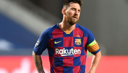

In [88]:
images = get_image_files(dest)
im = Image.open(images[0])
im.to_thumb(128)

In [89]:
failed = verify_images(images)
failed

(#0) []

In [90]:
failed.map(Path.unlink)

(#0) []

In [91]:
#categories
persons = ['fakhar','messi']

#dataloaders and datablock
men = DataBlock(
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct=0.2,seed=42),
    get_y = parent_label,
    item_tfms = Resize(128)

)

In [92]:
#dataloader
men = men.new(
    item_tfms = RandomResizedCrop(224,min_scale=0.3),
    batch_tfms = aug_transforms()
)
dls = men.dataloaders(path)


In [93]:
learn = cnn_learner(dls,resnet18,metrics=accuracy)
learn.fine_tune(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.612809,5.608194,0.243902,00:18


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,accuracy,time
0,0.895650,3.201249,0.243902,00:16
1,0.918228,1.230361,0.414634,00:16
2,0.846071,0.383923,0.853659,00:15
3,0.801218,0.181030,0.878049,00:18
4,0.718091,0.120929,0.951219,00:16
5,0.660003,0.118378,0.951219,00:16
6,0.595341,0.120635,0.951219,00:16
7,0.554403,0.116648,0.951219,00:16


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes sh

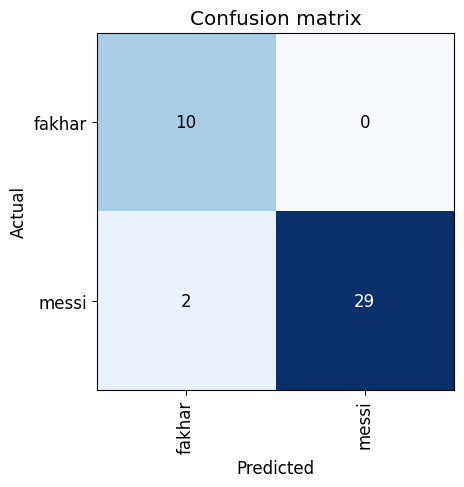

In [94]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

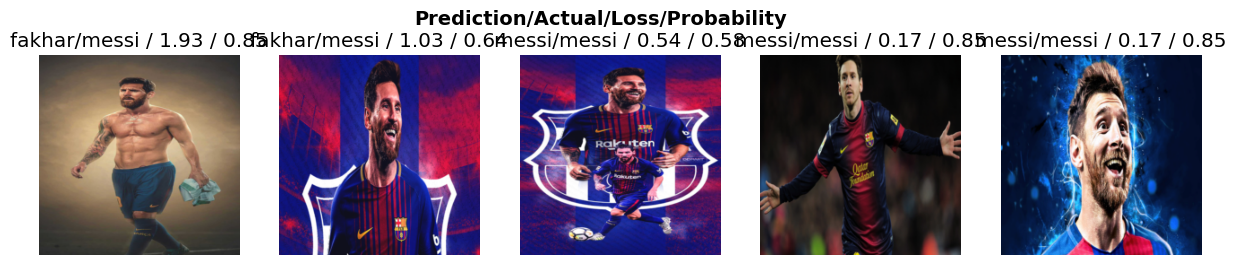

In [95]:
interp.plot_top_losses(5,nrows=1)

In [96]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [79]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [97]:
def image_classify(img):
  pred,pred_idx,probs = learn.predict(img)
  return dict(zip(persons,map(float,probs)))


In [98]:
image_classify('m3.jpeg')

{'fakhar': 0.014728156849741936, 'messi': 0.9852718114852905}

In [99]:
#exporting model and bring it to deployment
learn.export('model.pkl')

In [100]:
path = Path()
path.ls(file_exts='.pkl')

(#3) [Path('export.pkl'),Path('model3.pkl'),Path('model.pkl')]

In [101]:
learn_inf = load_learner(path/'model.pkl')


In [102]:
def image_classifyex(img):
  pred,pred_idx,probs = learn_inf.predict(img)
  return dict(zip(persons,map(float,probs)))


In [103]:
image_classifyex('IMG_20221126_135534.jpg')

{'fakhar': 0.999990701675415, 'messi': 9.319990567746572e-06}

In [104]:
!pip install gradio
import gradio as gr

image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['dp.JPG']
intf = gr.Interface(fn = image_classifyex, inputs = image,outputs = label,examples=examples)
intf.launch(inline=False,share=True)

<ipython-input-104-eb107957eed5>:4: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  image = gr.inputs.Image(shape=(192,192))
<ipython-input-104-eb107957eed5>:4: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  image = gr.inputs.Image(shape=(192,192))
<ipython-input-104-eb107957eed5>:5: GradioDeprecationWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  label = gr.outputs.Label()
<ipython-input-104-eb107957eed5>:5: GradioUnusedKwargWarning: You have unused kwarg parameters in Label, please remove them: {'type': 'auto'}
  label = gr.outputs.Label()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://ac0588974184177cc3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
